In [29]:
# Импорт модулей и библиотек

import numpy as np
import pandas as pd

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt 

In [2]:
def visualize_coefs(model, feature_names, n_top_features):

    coefs = model.coef_.ravel()
    positive_coefs = np.argsort(coefs)[-n_top_features:] # индексы самых больших по модулю положительных к-тов
    negative_coefs = np.argsort(coefs)[:n_top_features] # индексы самых больших по модулю отрицательных к-тов
    important_coefs = np.hstack([negative_coefs, positive_coefs])

    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "green" for c in coefs[important_coefs]]
    plt.bar(np.arange(2 * n_top_features), coefs[important_coefs], color=colors)
    feature_names = np.array(feature_names)
    
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), 
               feature_names[important_coefs],  # Порядок следования признаков и к-тов согласованы
               rotation=60, 
               ha='right')
    
    return(feature_names[positive_coefs], feature_names[negative_coefs])

In [3]:
# Чтение dataset.v.3.2.csv
dataset = pd.read_csv('_data/dataset.v.3.2.csv', sep=';')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35227 entries, 0 to 35226
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ticker       35227 non-null  object 
 1   year         35227 non-null  int64  
 2   month        35227 non-null  int64  
 3   day          35227 non-null  int64  
 4   title        35227 non-null  object 
 5   content      35227 non-null  object 
 6   T            35227 non-null  float64
 7   a1           35227 non-null  float64
 8   a2           35227 non-null  float64
 9   title_cln    35227 non-null  object 
 10  content_cln  35227 non-null  object 
dtypes: float64(3), int64(3), object(5)
memory usage: 3.0+ MB


In [16]:
# Подготовка данныx, вычисление класса Y

period = 30
dataset = dataset[dataset['T'] == period]
dataset = dataset[dataset['a2'].notnull()]

# Y=1, если котировка имела нисходящий тренд
dataset['Y'] = (dataset['a2'] < 0) * 1 

r0, r1 = dataset['Y'].value_counts() # кол-во примеров классов
w0, w1 = 1 - r0/len(dataset), 1 - r1/len(dataset) # веса классов

print(f'Количество записей: {len(dataset)}')
print(f'Класс 0 (рост котировки): {r0} примеров, вес: {round(w0, 2)}')
print(f'Класс 1 (падение котировки): {r1} примеров, вес: {round(w1, 2)}')

Количество записей: 35227
Класс 0 (рост котировки): 20418 примеров, вес: 0.42
Класс 1 (падение котировки): 14809 примеров, вес: 0.58


## Объясняющая переменная - токенизированные заголовки новостных статей (*title_cln*)

In [17]:
# Получение train и test-выборок

min_df = 1
test_size = 0.05

X = dataset['title_cln']
Y = dataset['Y']

X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size=test_size, 
                                                    random_state=42)

vectorizer = CountVectorizer(min_df=min_df)
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

# Балансировка SMOTE
smote = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f'Обучающая выборка: {X_train_resampled.shape[0]} записей')
print(f'Тестовая выборка: {X_test.shape[0]} записей')
print(f'Атрибутов: {X_test.shape[1]}')

print(f'После балансировки:\nКласс 0: {y_train_resampled.value_counts()[0]} примеров')
print(f'Kласс 1: {y_train_resampled.value_counts()[1]} примеров')

Обучающая выборка: 38820 записей
Тестовая выборка: 1762 записей
Атрибутов: 8953
После балансировки:
Класс 0: 19410 примеров
Kласс 1: 19410 примеров


In [18]:
# Токены, полученные из заголовков новостных статей

tokens = vectorizer.get_feature_names()
print(tokens[0:50])

['аа', 'ааа', 'аалитик', 'аба', 'абонент', 'абонентский', 'абрам', 'абрамов', 'абрамович', 'абрамченко', 'абсолют', 'абсолютно', 'абсолютный', 'абсорбировать', 'абу', 'абхазия', 'абызов', 'авангард', 'аванс', 'авантела', 'аварийный', 'авария', 'авг', 'август', 'авдеев', 'авдоляна', 'авиа', 'авиабилет', 'авиавласть', 'авиакатастрофа', 'авиакеросин', 'авиакомпания', 'авиалиния', 'авиалоукостер', 'авиаотрасль', 'авиапассажир', 'авиаперевозка', 'авиаперевозчик', 'авиапром', 'авиарейс', 'авиарынок', 'авиасообщение', 'авиастрахование', 'авиатехник', 'авиатопливо', 'авиаузел', 'авиахаб', 'авиахолдинг', 'авиация', 'авив']


In [19]:
df_X_train = pd.DataFrame.sparse.from_spmatrix(X_train, columns = tokens)
df_X_train

,аа,ааа,аалитик,аба,абонент,абонентский,абрам,абрамов,абрамович,абрамченко,...,ярославский,ярудейский,ярый,ястреб,ястребиный,ястёб,ятэк,ящик,ёлка,ёмкость
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33460,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33461,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33462,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33463,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# Ранжирование токенов по их частоте появления в корпусе

df_top_tokens = pd.DataFrame({'count': df_X_train.aggregate(func='sum', axis=0)})
df_top_tokens = df_top_tokens.reset_index().rename({'index':'token'}, axis=1)
df_top_tokens = df_top_tokens.sort_values(by='count', ascending=True)
df_top_tokens

,token,count
8952,ёмкость,1
2960,конвейер,1
2961,конверсия,1
6796,сбалансированный,1
2963,конвертерный,1
...,...,...
4534,ожидаться,4342
4381,облигация,5284
6696,руб,5565
1148,выпуск,5697


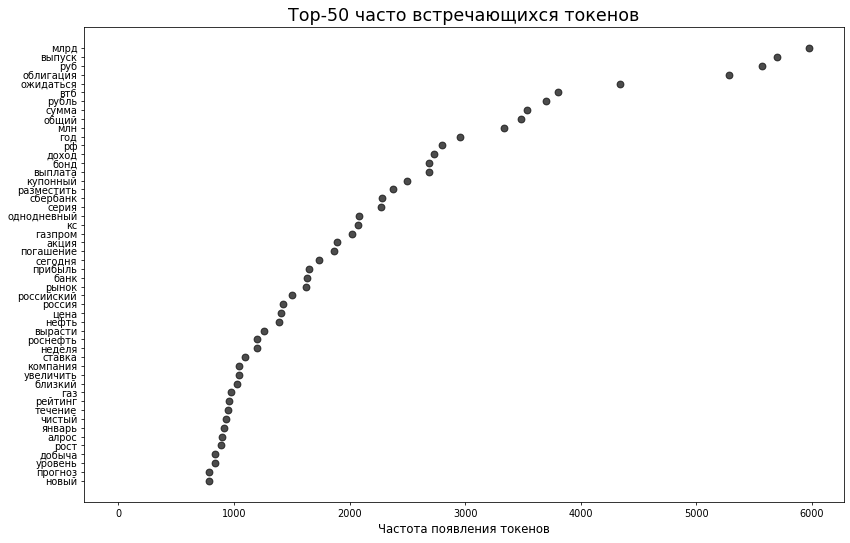

In [21]:
# Диаграмма: тор-50 часто встречающихся токенов

y = df_top_tokens['token'].values[-50:] # 50 "популярных" токенов
x = df_top_tokens['count'].values[-50:] # частота появления каждого из них

# Построенние графика
fig, ax = plt.subplots(figsize=(14,9), dpi= 70)
ax.hlines(y=y, xmin=1, xmax=50, color='gray', alpha=0.7, linewidth=0)
ax.scatter(y=y, x=x, s=50, color='black', alpha=0.7)

# Заголовок, названия оси абсцисс
ax.set_title('Тор-50 часто встречающихся токенов', fontdict={'size':18})
ax.set_xlabel('Частота появления токенов', fontdict={'size':12})

plt.show()

Text(0.5, 1.0, 'Распределение частот появления РЕДКО встречающихся токенов')

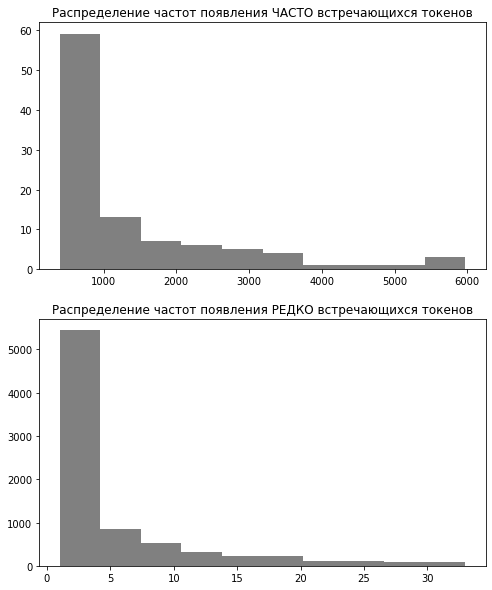

In [22]:
# Гистограмма распределения частот появления токенов

fig, ax = plt.subplots(2, figsize=(8,10))
ax[0].hist(df_top_tokens['count'][-100:], color='gray') # частоты появления "популярных" токенов
ax[1].hist(df_top_tokens['count'][:8000], color='gray') # частоты появления "непопулярных" токенов

ax[0].set_title('Распределение частот появления ЧАСТО встречающихся токенов', fontdict={'size':12})
ax[1].set_title('Распределение частот появления РЕДКО встречающихся токенов', fontdict={'size':12})

In [181]:
# Логистическая регрессия без тюнинга С-параметра

model = LogisticRegression(C=1, 
                           max_iter=1000,
                           class_weight = {1: w1, 0: w0})

model.fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_test)

print(f'Accuracy = {accuracy_score(y_test, y_pred)}')
print(f'Recall = {recall_score(y_test, y_pred)}')
print(f'Precision = {precision_score(y_test, y_pred)}')
print(f'F1 = {f1_score(y_test, y_pred)}')

Accuracy = 0.5539160045402951
Recall = 0.7387267904509284
Precision = 0.4860383944153578
F1 = 0.5863157894736842


In [185]:
# Логистическая регрессия с автоматическим тюнингом С-параметра

skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

c_range = np.logspace(-2, 3, 100)

model = LogisticRegressionCV(Cs=c_range, 
                             cv=skf, 
                             verbose=0, 
                             max_iter=1000)
                             
model.fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_test)

print(f'Accuracy = {accuracy_score(y_test, y_pred)}')
print(f'Recall = {recall_score(y_test, y_pred)}')
print(f'Precision = {precision_score(y_test, y_pred)}')
print(f'F1 = {f1_score(y_test, y_pred)}')

Accuracy = 0.5641316685584563
Recall = 0.5689655172413793
Precision = 0.4919724770642202
F1 = 0.5276752767527675


In [274]:
# Получение train и test-выборок
# Векторизация текстового поля с "осознанными" параметрами

min_df = 2
max_df = 5000
test_size = 0.05

X = dataset['title_cln']
Y = dataset['Y']

X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size=test_size, 
                                                    random_state=42)

vectorizer = CountVectorizer(min_df=min_df, max_df=max_df)
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

# Балансировка SMOTE
smote = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f'Обучающая выборка: {X_train_resampled.shape[0]} записей')
print(f'Тестовая выборка: {X_test.shape[0]} записей')
print(f'Атрибутов: {X_test.shape[1]}')

print(f'После балансировки:\nКласс 0: {y_train_resampled.value_counts()[0]} примеров')
print(f'Kласс 1: {y_train_resampled.value_counts()[1]} примеров')

Обучающая выборка: 38820 записей
Тестовая выборка: 1762 записей
Атрибутов: 5973
После балансировки:
Класс 0: 19410 примеров
Kласс 1: 19410 примеров


In [275]:
# Логистическая регрессия без тюнинга С-параметра

model = LogisticRegression(C=1, 
                           max_iter=1000,
                           class_weight = {1: w1, 0: w0})

model.fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_test)

print(f'Accuracy = {accuracy_score(y_test, y_pred)}')
print(f'Recall = {recall_score(y_test, y_pred)}')
print(f'Precision = {precision_score(y_test, y_pred)}')
print(f'F1 = {f1_score(y_test, y_pred)}')

Accuracy = 0.5516458569807038
Recall = 0.7307692307692307
Precision = 0.484182776801406
F1 = 0.5824524312896405


In [186]:
# Логистическая регрессия с автоматическим тюнингом С-параметра

skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

c_range = np.logspace(-2, 3, 100)

model = LogisticRegressionCV(Cs=c_range, 
                             cv=skf, 
                             verbose=0, 
                             max_iter=1000)
                             
model.fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_test)

print(f'Accuracy = {accuracy_score(y_test, y_pred)}')
print(f'Recall = {recall_score(y_test, y_pred)}')
print(f'Precision = {precision_score(y_test, y_pred)}')
print(f'F1 = {f1_score(y_test, y_pred)}')

Accuracy = 0.5641316685584563
Recall = 0.5689655172413793
Precision = 0.4919724770642202
F1 = 0.5276752767527675


(array(['обсуждение', 'доверять', 'консультация', 'полезный', 'настроить',
        'пойти', 'евро', 'перечисление', 'белоусов', 'записывать',
        'автоваз', 'интересант', 'относительно', 'бензоколонка',
        'беспошлинный', 'нацпрограмма', 'деталь', 'компенсационный',
        'заинтересованность', 'извиниться', 'игольчатый', 'запретить',
        'выноситься', 'отодвинуть', 'горняк', 'екредит', 'привычка',
        'присутствие', 'кипрский', 'перевалить', 'обдумать', 'калашников',
        'жизнь', 'входящий', 'баку'], dtype='<U21'),
 array(['повредить', 'вконтакте', 'виновница', 'золотопромышленник',
        'объявить', 'дисконтный', 'отступление', 'палата', 'зао', 'мусор',
        'прекратить', 'когда', 'кончиться', 'днепрометиза', 'негативно',
        'надо', 'ввозить', 'антидемпинговый', 'ажиотажный', 'отказываться',
        'живопись', 'аккредитив', 'оппозиция', 'ольга', 'инвестировать',
        'написать', 'превышение', 'делимобиль', 'ерс', 'предрекать',
        'ларин', 'объ

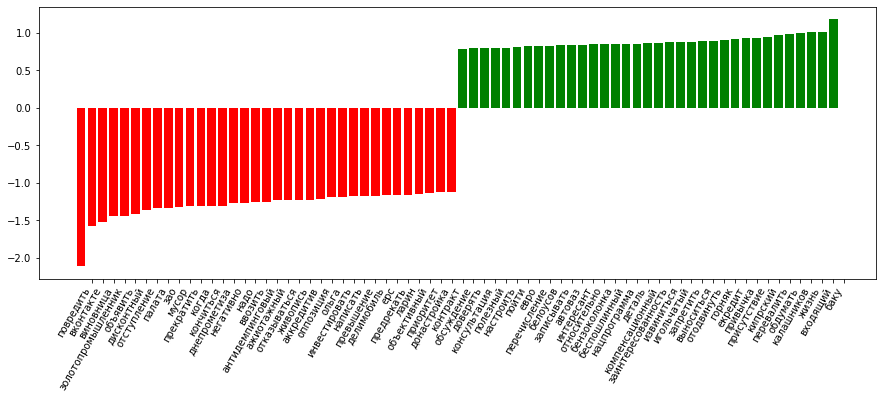

In [266]:
visualize_coefs(model, tokens, 35)

## Объясняющая переменная - токенизированные контенты новостных статей (*content_cln*)

In [23]:
# Получение train и test-выборок
# Векторизация текстового поля с "осознанными" параметрами

min_df = 1
max_df = 2000
test_size = 0.05

X = dataset['content_cln']
Y = dataset['Y']

X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size=test_size, 
                                                    random_state=42)

vectorizer = CountVectorizer(min_df=min_df)
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

# Балансировка SMOTE
smote = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f'Обучающая выборка: {X_train_resampled.shape[0]} записей')
print(f'Тестовая выборка: {X_test.shape[0]} записей')
print(f'Атрибутов: {X_test.shape[1]}')

print(f'После балансировки:\nКласс 0: {y_train_resampled.value_counts()[0]} примеров')
print(f'Kласс 1: {y_train_resampled.value_counts()[1]} примеров')

Обучающая выборка: 38820 записей
Тестовая выборка: 1762 записей
Атрибутов: 12862
После балансировки:
Класс 0: 19410 примеров
Kласс 1: 19410 примеров


In [24]:
# Токены, полученные из заголовков новостных статей
tokens = vectorizer.get_feature_names()

# X_test в датафрейм
df_X_train = pd.DataFrame.sparse.from_spmatrix(X_train, columns = tokens)

# Ранжирование токенов по их частоте появления в корпусе
df_top_tokens = pd.DataFrame({'count': df_X_train.aggregate(func='sum', axis=0)})
df_top_tokens = df_top_tokens.reset_index().rename({'index':'token'}, axis=1)
df_top_tokens = df_top_tokens.sort_values(by='count', ascending=True)

In [25]:
df_top_tokens

,token,count
4197,колесников,1
6038,непонимание,1
6035,неподходящий,1
11367,трёхкратный,1
6031,неплатёж,1
...,...,...
9616,рубль,8495
5334,млрд,8684
6445,облигация,9619
1734,выпуск,9727


Text(0.5, 1.0, 'Распределение частот появления РЕДКО встречающихся токенов')

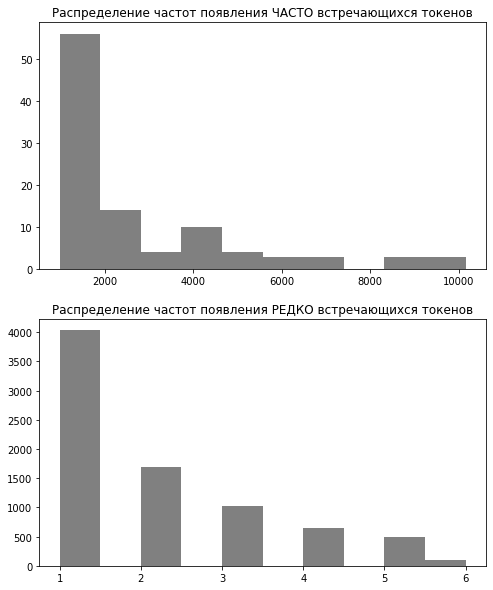

In [30]:
# Гистограмма распределения частот появления токенов

fig, ax = plt.subplots(2, figsize=(8,10))
ax[0].hist(df_top_tokens['count'][-100:], color='gray') # частоты появления "популярных" токенов
ax[1].hist(df_top_tokens['count'][:8000], color='gray') # частоты появления "непопулярных" токенов

ax[0].set_title('Распределение частот появления ЧАСТО встречающихся токенов', fontdict={'size':12})
ax[1].set_title('Распределение частот появления РЕДКО встречающихся токенов', fontdict={'size':12})

In [ ]:
# Получение train и test-выборок
# Векторизация текстового поля с "осознанными" параметрами

min_df = 2
max_df = 3000
test_size = 0.05

X = dataset['content_cln']
Y = dataset['Y']

X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size=test_size, 
                                                    random_state=42)

vectorizer = CountVectorizer(min_df=min_df)
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

# Балансировка SMOTE
smote = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f'Обучающая выборка: {X_train_resampled.shape[0]} записей')
print(f'Тестовая выборка: {X_test.shape[0]} записей')
print(f'Атрибутов: {X_test.shape[1]}')

print(f'После балансировки:\nКласс 0: {y_train_resampled.value_counts()[0]} примеров')
print(f'Kласс 1: {y_train_resampled.value_counts()[1]} примеров')

Обучающая выборка: 38820 записей
Тестовая выборка: 1762 записей
Атрибутов: 8757
После балансировки:
Класс 0: 19410 примеров
Kласс 1: 19410 примеров


In [ ]:
# Логистическая регрессия без тюнинга С-параметра

model = LogisticRegression(C=1, 
                           max_iter=1000,
                           class_weight = {1: w1, 0: w0})

model.fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_test)

print(f'Accuracy = {accuracy_score(y_test, y_pred)}')
print(f'Recall = {recall_score(y_test, y_pred)}')
print(f'Precision = {precision_score(y_test, y_pred)}')
print(f'F1 = {f1_score(y_test, y_pred)}')

Accuracy = 0.5550510783200908
Recall = 0.6644562334217506
Precision = 0.48546511627906974
F1 = 0.561030235162374


In [ ]:
# Логистическая регрессия с автоматическим тюнингом С-параметра

skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

c_range = np.logspace(-2, 3, 100)

model = LogisticRegressionCV(Cs=c_range, 
                             cv=skf, 
                             verbose=0, 
                             max_iter=1000, scoring='f1')
                             
model.fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_test)

print(f'Accuracy = {accuracy_score(y_test, y_pred)}')
print(f'Recall = {recall_score(y_test, y_pred)}')
print(f'Precision = {precision_score(y_test, y_pred)}')
print(f'F1 = {f1_score(y_test, y_pred)}')

Accuracy = 0.5805902383654937
Recall = 0.5411140583554377
Precision = 0.5093632958801498
F1 = 0.5247588424437301


(array(['нестабильный', 'зеландия', 'глобальный', 'бельё', 'мяч',
        'гибралтар', 'отнесение', 'поощрение', 'посмотреть', 'возбудить',
        'беззалоговый', 'генерация', 'немецкий', 'злотый', 'память',
        'мощь', 'орден', 'предостеречь', 'можно', 'бельянин', 'командир',
        'гибридный', 'накапливаться', 'маять', 'наводить', 'бюджетный',
        'литвиненко', 'елена', 'понижать', 'маховский', 'появление',
        'быть', 'банк', 'изучаться', 'вылиться'], dtype='<U24'),
 array(['повыситься', 'замалчивать', 'вздохнуть', 'ак', 'авиарынок',
        'лена', 'кризис', 'питать', 'позитроника', 'лето', 'наградить',
        'лапландский', 'полицейский', 'книжный', 'измениться', 'гана',
        'перемахнуть', 'обыграть', 'взлёт', 'отстреливать', 'брифинг',
        'общаться', 'костыгин', 'комплектный', 'пересчитать', 'зимин',
        'мощность', 'нзт', 'онь', 'даглас', 'вынужденный', 'пациент',
        'выбирать', 'поручительство', 'золотодобыча'], dtype='<U24'))

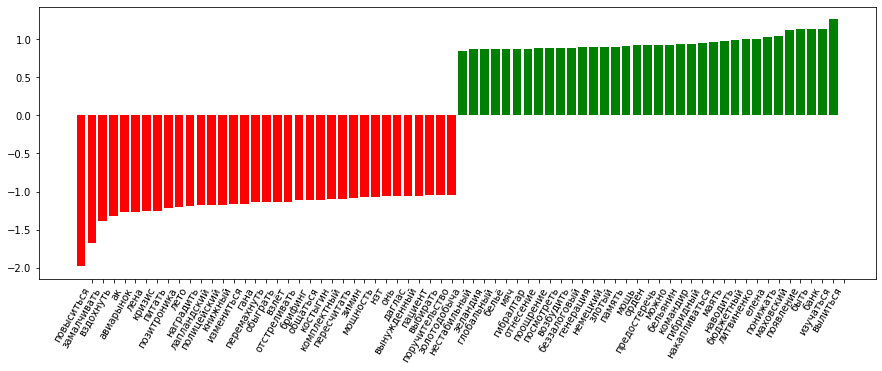

In [ ]:
visualize_coefs(model, tokens, 35)